<a href="https://colab.research.google.com/github/rmorlowski/Machine-Learning/blob/master/MNIST_Neural_Networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Networks

This individual assignment involves fitting a neural network to the MNIST data, testing alternative network structures, activation functions, optimization methods, and/or hyperparameter settings. As in Assignment 6, we will assess classification performance accuracy and processing time. Python TensorFlow should be used for Assignment 6. (If you are experience difficulty installing TensorFlow, Python Scikit Learn may be used as an alternative for Assignment 6.)

The Benchmark Experiment. Tested neural network structures should be explored within a benchmark experiment, a factorial design with at least two levels on each of two experimental factors (at least a 2x2 completely crossed design). But due to the time required to fit each neural network, we will observe only one trial for each cell in the design. Also, we will be using a simple training-and-test split with the split having been performed previously. That is, we use the training and test sets that come with MNIST.

Relevant documentation includes:

*   [Agéron, handson-ml](https://github.com/ageron/handson-ml/blob/master/11_deep_learning.ipynb)
*   [Raschka, python-machine-learning-book](https://github.com/rasbt/python-machine-learning-book/blob/master/code/ch12/ch12.ipynb)
*   [Lynda - Building and Deploying Deep Learning with TensorFlow](https://www.lynda.com/Google-TensorFlow-tutorials/Add-custom-visualizations-TensorBoard/601800/647738-4.html)
*   [TensorFlow Tutorials](https://www.tensorflow.org/tutorials)

An example experiment could include two values for the number of nodes per inner layer and two values for the number of inner layers. Various machine learning hyperparameter settings may be used.

### Section 1: Ingest - Data Survey

Gather data for the MNIST dataset.  These data consist of 70 thousand observations. Utilize the first 60 thousand as a model development set and the final 10 thousand as a holdout test set.

For this assignment we will develop a neural network classifier that may be used to predict which of the ten digits is being written.


First, let's make sure this notebook works well in both python 2 and 3, import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures:

In [0]:
import tensorflow as tf
import time
from sklearn.neural_network import MLPClassifier
from tensorboardcolab import *

Using TensorFlow backend.


In [0]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

In [0]:
import pandas as pd
import statsmodels.formula.api as smf  # R-like model specification
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score, make_scorer 
from sklearn.model_selection import cross_val_score, train_test_split

Setup ngrok and run TensorBoard in Colab

In [0]:
#!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
#!unzip ngrok-stable-linux-amd64.zip

In [0]:
#LOG_DIR = './log'
#get_ipython().system_raw(
#    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
#    .format(LOG_DIR)
#)

In [0]:
#get_ipython().system_raw('./ngrok http 6006 &')

**MNIST Dataset**

Load Train/Test split of the dataset in preparation for modeling.  Split the MNIST dataset into a training set and a test set (take the first 60,000 instances for training, and the remaining 10,000 for testing).

In [0]:
#split train & test data
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

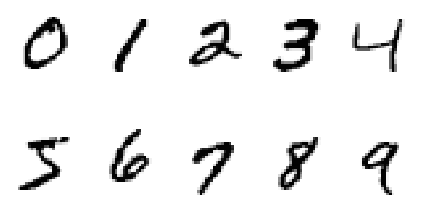

In [0]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(10):
    img = X_train[y_train == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('./figures/mnist_all.png', dpi=300)
plt.show()

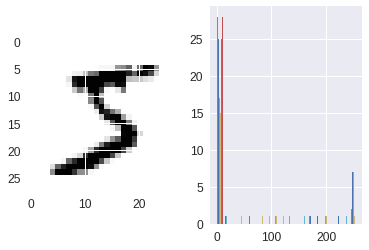

In [0]:
# Let's plot an image and histogram to quickly visualize the pixel data.
%matplotlib inline

# We'll show the image and its pixel value histogram side-by-side.
_, (ax1, ax2) = plt.subplots(1, 2)

# To interpret the values as a 28x28 image, we need to reshape
# the numpy array, which is one dimensional.
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);

ax2.hist(X_train[0], bins=20, range=[0,255]);

The large number of 0 values correspond to the background of the image, another large mass of value 255 is black, and a mix of grayscale transition values in between. Both the image and histogram look sensible. But, it's good practice when training image models to normalize values to be centered around 0.

We'll do that next. The normalization code is fairly short, and it may be tempting to assume we haven't made mistakes, but we'll double-check by looking at the rendered input and histogram again. Malformed inputs are a surprisingly common source of errors when developing new models.

#### Scale Data

In [0]:
# scale the data for use in the neural network
X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
y_train = y_train.astype(np.int32)
y_test = y_test.astype(np.int32)

In [0]:
#test split 'train'
X_train.shape

(60000, 784)

In [0]:
#test split 'test'
X_test.shape

(10000, 784)

### Section 2: EDA

#### Visualize MNIST

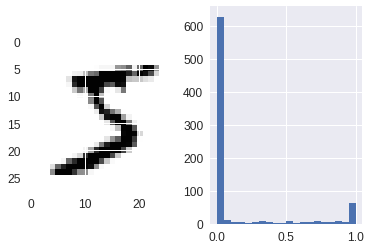

In [0]:
# We again plot the image and histogram to check that we 
# haven't mangled the data.
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.hist(X_train[0], bins=20, range=[0, 1]);

We've retained the correct image data while properly rescaling to the range [-0.5, 0.5].

Training data shape (60000, 784)


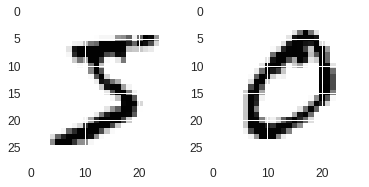

In [0]:
#check data in training set as visual:
print('Training data shape', X_train.shape)
_, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(X_train[0].reshape(28, 28), cmap=plt.cm.Greys);
ax2.imshow(X_train[1].reshape(28, 28), cmap=plt.cm.Greys);

In [0]:
#define confusion matrix plot
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

In [0]:
X_train.dtype

dtype('float32')

### Section 3: Modeling - Neural Networks

In summary, this assignment asks you to fit a number of neural networks, comparing processing time and performance across experimental treatments.

#### Tensorflow DNNClassifier Version - 2D with 10 Neurons per layer

Begin by setting the neural network parameters, the number of layers, and the number of neurons per layer.

In [0]:
#Model 2a - 2D with 10 Neurons each layer
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_2a = tf.estimator.DNNClassifier(hidden_units=[10,10], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_2a = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_2a.train(input_fn=input_fn_2a)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpbedwv36g', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2037025588>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
To construct input pipelines, use the `tf.

In [0]:
#evaluate training accuracy (2a)
train_2a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_2a = dnn_clf_2a.evaluate(input_fn=train_2a_input_fn)
eval_results_train_2a

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:08:17Z
INFO:tensorflow:Graph was finalized.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /tmp/tmpbedwv36g/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:08:18
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.9349, average_loss = 0.22256592, global_step = 60000, loss = 28.473251
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmpbedwv36g/model.ckpt-60000


{'accuracy': 0.9349,
 'average_loss': 0.22256592,
 'global_step': 60000,
 'loss': 28.473251}

In [0]:
#evaluate test accuracy (2a)
test_2a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_2a = dnn_clf_2a.evaluate(input_fn=test_2a_input_fn)
eval_results_test_2a

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:08:18Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbedwv36g/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:08:19
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.929, average_loss = 0.25546125, global_step = 60000, loss = 32.33687
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmpbedwv36g/model.ckpt-60000


{'accuracy': 0.929,
 'average_loss': 0.25546125,
 'global_step': 60000,
 'loss': 32.33687}

In [0]:
#confusion matrix for 2a predictions
raw_predictions_2a = dnn_clf_2a.predict(input_fn=test_2a_input_fn)
predictions_2a = [p['class_ids'][0] for p in raw_predictions_2a]
confusion_matrix_2a = tf.confusion_matrix(y_test, predictions_2a)

with tf.Session():
    print('\nConfusion Matrix model 2a:\n', tf.Tensor.eval(confusion_matrix_2a,feed_dict=None, session=None))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbedwv36g/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.

Confusion Matrix model 2a:
 [[ 956    0    0    1    2    7    8    5    1    0]
 [   0 1109    2    4    1    2    2    1   13    1]
 [  10    8  938   12    7    7   14   13   21    2]
 [   4    1   31  920    0   26    2   11   13    2]
 [   1    0   10    3  921    2    9    2    3   31]
 [   9    3    2   23    6  798   11    6   28    6]
 [  11    3   11    1    7   16  902    0    7    0]
 [   2   11   19    3    7    4    0  956    2   24]
 [   5   13   10    7   12   21    9    9  876   12]
 [   8    8    0    8   33   10    0   19    9  914]]


#### Tensorflow DNNClassifier Version - 2D with 20 Neurons per layer

(2) Model 2 - 2 layers with 20 nodes per layer

In [0]:
#Model 2b - 2D with 20 Neurons each layer
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_2b = tf.estimator.DNNClassifier(hidden_units=[20,20], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_2b = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_2b.train(input_fn=input_fn_2b)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmp8fqtq_pm', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2036432fd0>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph wa

In [0]:
#evaluate training accuracy (2b)
train_2b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_2b = dnn_clf_2a.evaluate(input_fn=train_2b_input_fn)
eval_results_train_2b

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:10:04Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpbedwv36g/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:10:05
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.9349, average_loss = 0.22256592, global_step = 60000, loss = 28.473251
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmpbedwv36g/model.ckpt-60000


{'accuracy': 0.9349,
 'average_loss': 0.22256592,
 'global_step': 60000,
 'loss': 28.473251}

In [0]:
#evaluate test accuracy (2b)
test_2b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_2b = dnn_clf_2b.evaluate(input_fn=test_2a_input_fn)
eval_results_test_2b

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:10:06Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmp8fqtq_pm/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:10:06
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.9555, average_loss = 0.15477096, global_step = 60000, loss = 19.59126
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmp8fqtq_pm/model.ckpt-60000


{'accuracy': 0.9555,
 'average_loss': 0.15477096,
 'global_step': 60000,
 'loss': 19.59126}

#### Tensorflow DNNClassifier Version - 5D with 20 Neurons per layer

(3) Model 3 - 5 layers with 20 nodes per layer

In [0]:
#Model 5a - 5D with 20 Neurons each layer
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_5a = tf.estimator.DNNClassifier(hidden_units=[20,20,20,20,20], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_5a = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_5a.train(input_fn=input_fn_5a)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmplxg19xj0', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f202da1e470>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph wa

In [0]:
#evaluate training accuracy (5a)
train_5a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_5a = dnn_clf_5a.evaluate(input_fn=train_5a_input_fn)
eval_results_train_5a

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:12:00Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplxg19xj0/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:12:01
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.98588336, average_loss = 0.04884149, global_step = 60000, loss = 6.2483783
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmplxg19xj0/model.ckpt-60000


{'accuracy': 0.98588336,
 'average_loss': 0.04884149,
 'global_step': 60000,
 'loss': 6.2483783}

In [0]:
#evaluate test accuracy (5a)
test_5a_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_5a = dnn_clf_5a.evaluate(input_fn=test_5a_input_fn)
eval_results_test_5a

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:12:02Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplxg19xj0/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:12:02
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.9582, average_loss = 0.19080032, global_step = 60000, loss = 24.15194
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmplxg19xj0/model.ckpt-60000


{'accuracy': 0.9582,
 'average_loss': 0.19080032,
 'global_step': 60000,
 'loss': 24.15194}

In [0]:
#confusion matrix for 5a predictions
raw_predictions_5a = dnn_clf_5a.predict(input_fn=test_5a_input_fn)
predictions_5a = [p['class_ids'][0] for p in raw_predictions_5a]
confusion_matrix_5a = tf.confusion_matrix(y_test, predictions_5a)

with tf.Session():
    print('\nConfusion Matrix model 5a:\n', tf.Tensor.eval(confusion_matrix_5a,feed_dict=None, session=None))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmplxg19xj0/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Confusion Matrix model 5a:
 [[ 962    0    3    0    0    3    4    3    4    1]
 [   0 1118    4    3    1    1    4    0    4    0]
 [   5    3  996    4    2    1    2    9    9    1]
 [   0    1   14  953    0   13    0    6    8   15]
 [   1    0    4    1  932    0   14    4    1   25]
 [   3    0    2   12    2  845    9    4    8    7]
 [   8    1    6    0    5   11  924    1    2    0]
 [   1    3   13    2    4    2    0  986    0   17]
 [   2    2   11   14    5    9    7    5  915    4]
 [   1    6    1   11   16    8    1    9    5  951]]


#### Tensorflow DNNClassifier Version - 5D with 50 Neurons per layer

(4) Model 4 - 5 layers with 50 nodes per layer

In [0]:
#Model 5b - 5D with Mixed Neurons each layer (50,50,50,50,55)
%%time
feature_cols = [tf.feature_column.numeric_column("X", shape=[28 * 28])]
dnn_clf_5b = tf.estimator.DNNClassifier(hidden_units=[50,50,50,50,50], n_classes=10,
                                     feature_columns=feature_cols)

input_fn_5b = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, num_epochs=50, batch_size=50, shuffle=True)
dnn_clf_5b.train(input_fn=input_fn_5b)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpj8o8tr2j', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f2036cfb860>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph wa

In [0]:
#evaluate training accuracy (5b)
train_5b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_train}, y=y_train, shuffle=False)
eval_results_train_5b = dnn_clf_5b.evaluate(input_fn=train_5b_input_fn)
eval_results_train_5b

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:21:40Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj8o8tr2j/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:21:41
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.99435, average_loss = 0.018499812, global_step = 60000, loss = 2.3667138
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmpj8o8tr2j/model.ckpt-60000


{'accuracy': 0.99435,
 'average_loss': 0.018499812,
 'global_step': 60000,
 'loss': 2.3667138}

In [0]:
#evaluate test accuracy (5a)
test_5b_input_fn = tf.estimator.inputs.numpy_input_fn(
    x={"X": X_test}, y=y_test, shuffle=False)
eval_results_test_5b = dnn_clf_5b.evaluate(input_fn=test_5b_input_fn)
eval_results_test_5b

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2019-02-17T23:21:42Z
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj8o8tr2j/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2019-02-17-23:21:43
INFO:tensorflow:Saving dict for global step 60000: accuracy = 0.9606, average_loss = 0.31787717, global_step = 60000, loss = 40.237617
INFO:tensorflow:Saving 'checkpoint_path' summary for global step 60000: /tmp/tmpj8o8tr2j/model.ckpt-60000


{'accuracy': 0.9606,
 'average_loss': 0.31787717,
 'global_step': 60000,
 'loss': 40.237617}

In [0]:
#confusion matrix for 5b predictions
raw_predictions_5b = dnn_clf_5b.predict(input_fn=test_5b_input_fn)
predictions_5b = [p['class_ids'][0] for p in raw_predictions_5b]
confusion_matrix_5b = tf.confusion_matrix(y_test, predictions_5b)

with tf.Session():
    print('\nConfusion Matrix Model 5b:\n', tf.Tensor.eval(confusion_matrix_5b,feed_dict=None, session=None))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpj8o8tr2j/model.ckpt-60000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.

Confusion Matrix Model 5b:
 [[ 962    0    1    3    1    2    3    3    4    1]
 [   0 1122    1    3    0    1    1    3    4    0]
 [   1    6  991   16    2    1    2    5    8    0]
 [   0    0    4  991    0    6    0    2    5    2]
 [   4    1    9    0  933    0    7    4    1   23]
 [   5    0    0   22    0  851    5    1    4    4]
 [   6    3    2    1    7   16  914    0    9    0]
 [   1    3   15    8    3    2    0  984    2   10]
 [   8    1    8   20    3    9    2    5  911    7]
 [   4    3    0   16   20    7    1    7    4  947]]


In [0]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [0]:
#tbc=TensorBoardColab()

### Section 4:  Conclusion

**Management problem: ** Suppose you are a financial institution evaluating machine learning technologies for optical character recognition. Initial testing is on the MNIST digits. What can you conclude from your benchmark study? Which neural network typology and hyperparameter settings would you recommend as being the most trustworthy?

>**Summary Table of Models:**


>Number of Layers | Nodes Per Layer | Processing Time | Train Accuracy | Test Accuracy
>--- | ---
>2 | 10 | 2min 35s | 0.9349 | 0.929
>2 | 20 | 2min 42s | 0.9349 | 0.9555
>5 | 20 | 2min 57s | 0.9858| 0.9582
>5 | 50 | 3min 26s | 0.9944 | 0.9606

**In Conclusion:**

After fitting a number of neural networks, processing time and performance was compared across experimental treatments.

The results showed:

*    The neural network classification model with 5 layers and 50 nodes per layer resulted in the most accurate predictions for handwritten digits.
*    Increasing the number of layers and nodes per layer increased accuracy.
*    As the number of layers and nodes increased, the processing time was slower.

The final recommendation to the financial institution is to implement the neural network classificaiton model with 5 layers and 50 nodes per layer.  Although this model takes longer to process, it results in the most accurate predictions and is the most trustworthy.